In [1]:
cd ..

/Users/jwen/Stanford/projects/wildfire_smoke


In [2]:
cd src

/Users/jwen/Stanford/projects/wildfire_smoke/src


In [12]:
from train_pipeline import fai_data_utils as fdu
#from metrics import lovasz as lov_loss
import fastai.vision as faiv
import fastai.core as faic
import torch
import time
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

## Reading in data
* Using custom function written to interface with fastai 

In [5]:
src = (fdu.SegmentationChannelList.from_folders(path='../data/crops/train/', bands=['true_color'])
                         .filter_by_func(fdu.keep_true_color)
                         .split_by_rand_pct(0.1)
                         .label_from_func(fdu.get_mask, classes=np.array(['smoke'])))

In [6]:
data = (src.transform(faiv.get_transforms(do_flip=True, 
                         flip_vert=True, 
                         max_rotate=180, 
                         max_zoom=1.2, 
                         max_lighting=0.5,
                         max_warp=0.1, 
                         p_affine=0.75, 
                         p_lighting=0.75), size=300, tfm_y=True)
        .databunch(bs=4))

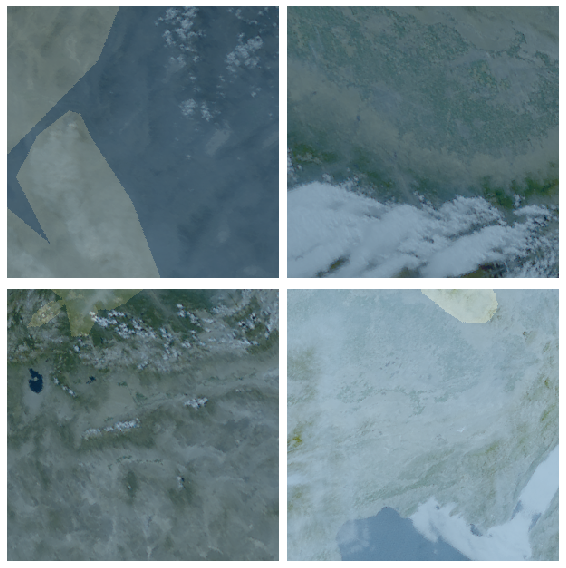

In [8]:
data.show_batch()

In [536]:
## from https://nbviewer.jupyter.org/github/wwymak/spacenet-buildings/blob/master/improving%20semantic%20segmentation.ipynb
def accuracy_pixel(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

## Find the starting learning rate

In [65]:
wd =1e-2
metrics = [accuracy_pixel, faiv.dice]
learn = faiv.unet_learner(data, faiv.models.resnet34, metrics=metrics, wd=wd, loss_func=faiv.BCEWithLogitsFlat())
learn.to_fp32(); ## change to 16 for half precision training on GPU

In [66]:
since = time.time()

learn.lr_find()

time_elapsed = time.time() - since
print('Learning rate finder complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Learning rate finder complete in 24m 0s


Min numerical gradient: 1.45E-05
Min loss divided by 10: 1.10E-03


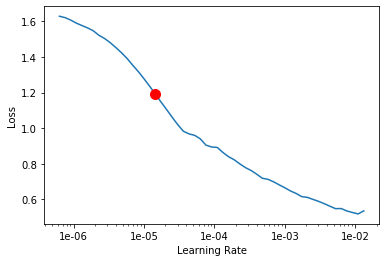

In [67]:
learn.recorder.plot(suggestion=True)

In [ ]:
lr=7e-06
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [192]:
data

ImageDataBunch;

Train: LabelList (3714 items)
x: SegmentationChannelList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationChannelLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: ../data/crops/train;

Valid: LabelList (412 items)
x: SegmentationChannelList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationChannelLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: ../data/crops/train;

Test: None

* training taking too long, moving to Google collab notebook

## Testing road unet...

In [483]:
src_temp = (fdu.SegmentationChannelList.from_folders(path='../data/temp_testing_roads/train/', 
                                                     bands=['true_color'])
                         .filter_by_func(fdu.keep_true_color)
                         .split_by_rand_pct(0.1)
                         .label_from_func(fdu.get_mask, classes=np.array(['road'])))

data_temp = (src_temp.transform(faiv.get_transforms(do_flip=True, 
                         flip_vert=True, 
                         max_rotate=180, 
                         max_zoom=1.2, 
                         max_lighting=0.5,
                         max_warp=0.1, 
                         p_affine=0.75, 
                         p_lighting=0.75), size=256, tfm_y=True)
        .databunch(bs=4))

In [484]:
wd =1e-2
metrics = [faiv.dice]
learn_temp = faiv.unet_learner(data_temp, faiv.models.resnet34, metrics=metrics, wd=wd, loss_func=faiv.BCEWithLogitsFlat())

In [485]:
learn_temp.load('/Users/jwen/Stanford/projects/wildfire_smoke/src/models/roads_test_bce')

Learner(data=ImageDataBunch;

Train: LabelList (190 items)
x: SegmentationChannelList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationChannelLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/temp_testing_roads/train;

Valid: LabelList (21 items)
x: SegmentationChannelList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationChannelLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/temp_testing_roads/train;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

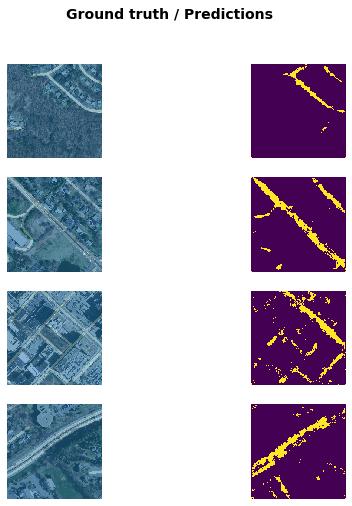

In [486]:
learn_temp.show_results()

In [88]:
pred_batch_ex = learn_temp.pred_batch(fastai.basic_data.DatasetType.Valid)

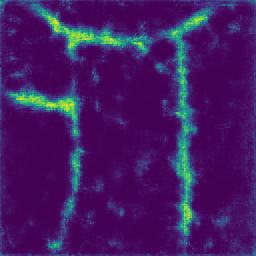

In [90]:
faiv.Image(pred_batch_ex[2])

In [27]:
import fastai
ds_y = data_temp.dl(fastai.basic_data.DatasetType.Valid).dataset.y

In [91]:
pred_batch_ex[2].shape

torch.Size([1, 256, 256])

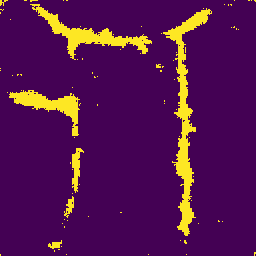

In [92]:
new_mask = torch.zeros((1, *pred_batch_ex[2].shape[-2:])).float()
new_mask[pred_batch_ex[2] > 0.3]=1.0

faiv.Image(new_mask)

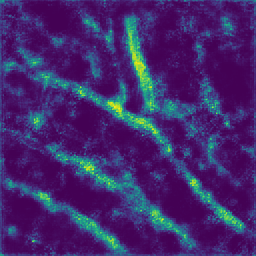

In [33]:
ds_y.reconstruct(faiv.grab_idx(blah, 0))

In [441]:
from fastai.vision.interpret import SegmentationInterpretation

In [487]:
interp_temp = SegmentationInterpretation.from_learner(learn_temp)

In [488]:
top_losses_temp, top_idxs_temp = interp_temp.top_losses((256,256), largest=True)

In [555]:
learn_temp.data

ImageDataBunch;

Train: LabelList (190 items)
x: SegmentationChannelList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationChannelLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/temp_testing_roads/train;

Valid: LabelList (21 items)
x: SegmentationChannelList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationChannelLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/temp_testing_roads/train;

Test: None

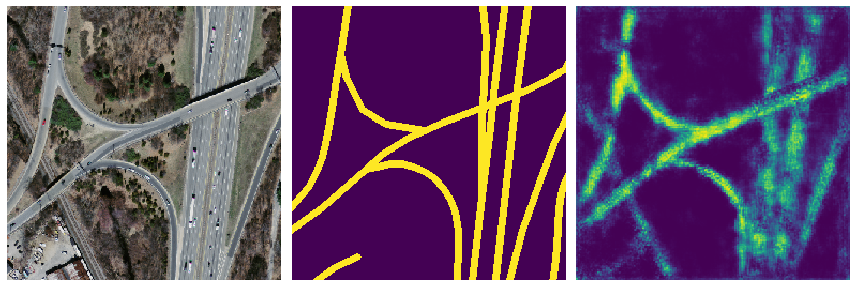

In [509]:
fdu.show_interp_xyz(learn_temp, interp_temp, idx=5, data_type='valid')

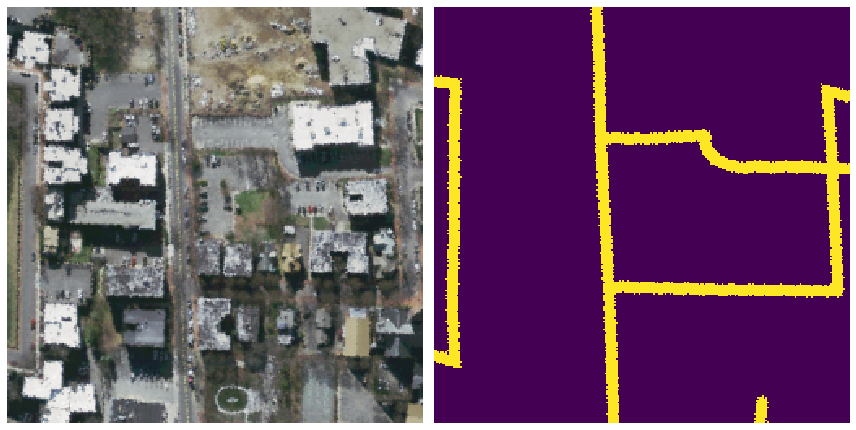

In [515]:
fdu.show_interp_xyz(learn_temp, idx=180, data_type='train')

In [535]:
interp_temp.preds[0]
#learn_temp.data.valid_ds[0][1].data

tensor([[[0.3614, 0.2039, 0.1067,  ..., 0.2269, 0.3950, 0.4127],
         [0.2596, 0.1402, 0.0612,  ..., 0.1457, 0.3125, 0.2984],
         [0.3221, 0.1941, 0.0841,  ..., 0.1134, 0.2248, 0.2289],
         ...,
         [0.2350, 0.2210, 0.1973,  ..., 0.3312, 0.3859, 0.2691],
         [0.3860, 0.3499, 0.3237,  ..., 0.3437, 0.4095, 0.2845],
         [0.3958, 0.3188, 0.3585,  ..., 0.4146, 0.4404, 0.3576]]])

In [619]:
## from https://nbviewer.jupyter.org/github/wwymak/spacenet-buildings/blob/master/improving%20semantic%20segmentation.ipynb
def accuracy_pixel2(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

def dice(input, targs):
    "Dice coefficient metric for binary target."
    
    # Threshold targs
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1) 
    
    # Compute dice
    intersect = (input * targs).sum(dim=1).float()
    union = (input + targs).sum(dim=1).float()    
    dice = 2. * intersect / union
    
    # Replace zero union values with 1
    dice[union == 0.] = 1
    
    # Return mean
    return dice.mean()

In [587]:
one_batch = learn_temp.data.one_batch()
batch_target = one_batch[1]
batch_target_squeeze = batch_target.squeeze(1)
batch_pred = learn_temp.pred_batch(one_batch)
batch_pred_squeeze = batch_pred.squeeze(1)

In [546]:
blah = interp_temp.preds[0]
zing = learn_temp.data.valid_ds[0][1].data

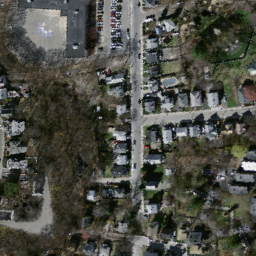

In [590]:
faiv.Image(one_batch[0][0])

In [604]:
blah = learn_temp.predict(faiv.Image(one_batch[0][0]))

In [647]:
one_batch[0].shape

torch.Size([4, 3, 256, 256])

In [643]:
one_batch[1].squeeze(1).shape

torch.Size([4, 256, 256])

In [620]:
dice(one_batch[1], blah[1])

RuntimeError: The size of tensor a (768) must match the size of tensor b (65536) at non-singleton dimension 1

## Test the data loading function and transformations

In [13]:
tf_test = (fdu.SegmentationChannelList.from_folders(path='../data/temp_crops/train/', 
                                                     bands=['true_color'])
                         .filter_by_func(fdu.keep_true_color)
                         .split_by_rand_pct(0.25)
                         .label_from_func(fdu.get_mask, classes=np.array(['smoke'])))

# tfms = faiv.get_transforms(do_flip=True, 
#                          flip_vert=True, 
#                          max_rotate=180, 
#                          max_zoom=1.2, 
#                          max_lighting=0.5,
#                          max_warp=0.1, 
#                          p_affine=0.75, 
#                          p_lighting=0.75)

tfms = faiv.get_transforms(do_flip=True, 
                           flip_vert=False, 
                           max_rotate=10.0, 
                           max_zoom=1.1, 
                           max_lighting=0.2, 
                           max_warp=0.2, 
                           p_affine=0.75, 
                           p_lighting=0.75)

tf_bunch_temp = (tf_test.transform(tfms, size=300, tfm_y=True)
        .databunch(bs=3))

# tf_bunch_temp = (tf_test.databunch(bs=3))

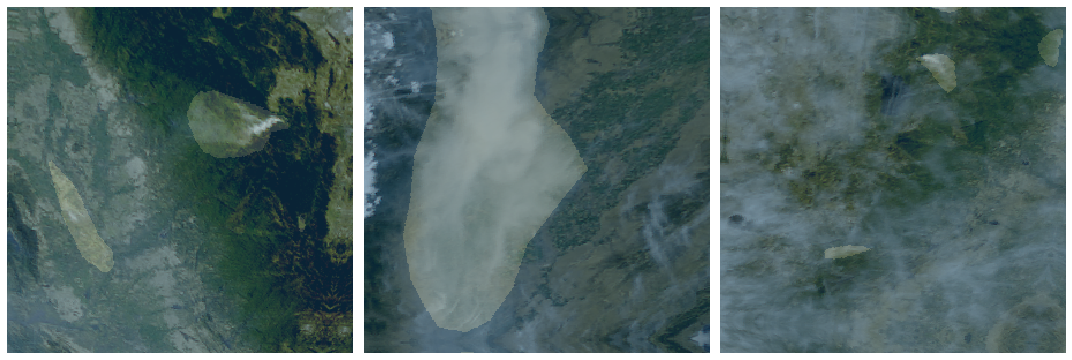

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15,30))
axs[0].axis('off')
temp_data = tf_bunch_temp.train_ds[0]
temp_data[0].show(ax=axs[0], y=temp_data[1], alpha=0.3)
axs[1].axis('off')
temp_data = tf_bunch_temp.train_ds[1]
temp_data[0].show(ax=axs[1], y=temp_data[1], alpha=0.3)
axs[2].axis('off')
temp_data = tf_bunch_temp.train_ds[2]
temp_data[0].show(ax=axs[2], y=temp_data[1], alpha=0.3)
plt.tight_layout()

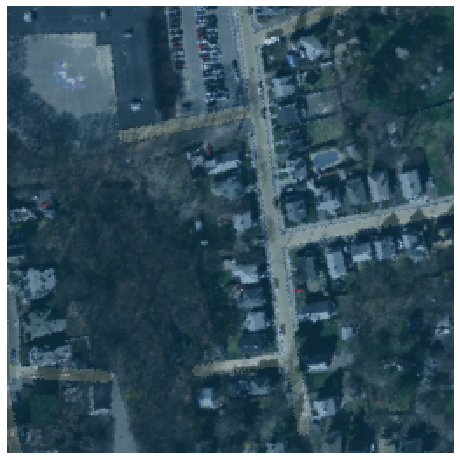

In [418]:
fig, ax = plt.subplots(1, 1, figsize=(8,15))
ax.axis('off')
temp = learn_temp.data.train_ds[0]
temp[0].show(ax=ax, y=temp[1], alpha=0.3)

In [335]:
# see what show results is using....
import inspect

In [106]:
print(inspect.getsource(interp_temp.show_xyz))

    def show_xyz(self, i, classes:list=None, sz=10):
        'show (image, true and pred) from self.ds with color mappings, optionally only plot'
        x,y = self.ds[i]
        self.ds.show_xys([x],[y], figsize=(sz/2,sz/2))
        self._interp_show(ImageSegment(self.y_true[i]), classes, sz=sz, title_suffix='true')
        self._interp_show(ImageSegment(self.pred_class[i][None,:]), classes, sz=sz, title_suffix='pred')



In [104]:
print(inspect.getsource(valid_ds.show_xys))

    def show_xys(self, xs, ys, figsize: Tuple[int, int] = (8, 8), **kwargs):

        rows = int(math.sqrt(len(xs)))

        fig, axs = plt.subplots(rows, rows, figsize=figsize)

        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            ax.axis('off')

            # for opening targets as 2 channel
            # y = faiv.Image(ys[i].data[1:2, :, :]), alpha = 0

            faiv.Image(xs[i].data[0:3, :, :]).show(ax=ax, y=ys[i], alpha=0.3, **kwargs)

        plt.tight_layout()



In [11]:
lines = inspect.getsource(learn_temp.show_results)
print(lines)

    def show_results(self, ds_type=DatasetType.Valid, rows:int=5, **kwargs):
        "Show `rows` result of predictions on `ds_type` dataset."
        #TODO: get read of has_arg x and split_kwargs_by_func if possible
        #TODO: simplify this and refactor with pred_batch(...reconstruct=True)
        n_items = rows ** 2 if self.data.train_ds.x._square_show_res else rows
        if self.dl(ds_type).batch_size < n_items: n_items = self.dl(ds_type).batch_size
        ds = self.dl(ds_type).dataset
        self.callbacks.append(RecordOnCPU())
        preds = self.pred_batch(ds_type)
        *self.callbacks,rec_cpu = self.callbacks
        x,y = rec_cpu.input,rec_cpu.target
        norm = getattr(self.data,'norm',False)
        if norm:
            x = self.data.denorm(x)
            if norm.keywords.get('do_y',False):
                y     = self.data.denorm(y, do_x=True)
                preds = self.data.denorm(preds, do_x=True)
        analyze_kwargs,kwargs = split_kwargs_by_func(kwargs

In [102]:
import fastai

In [103]:
valid_ds = data_temp.dl(fastai.basic_data.DatasetType.Valid).dataset

In [14]:
inspect.getsource(data_temp.dl(fastai.basic_data.DatasetType.Train).dataset.x.show_xyzs)

"    def show_xyzs(self, xs, ys, zs, figsize: Tuple[int, int] = (8, 8), **kwargs):\n\n        # rows = int(math.sqrt(len(xs)))\n        #\n        # fig, axs = plt.subplots(rows, rows, figsize=figsize)\n        #\n        # for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):\n        #     ax.axis('off')\n        #\n        #     faiv.Image(xs[i].data[0:3, :, :]).show(ax=ax, y=ys[i], alpha=0.3, **kwargs)\n\n        print(xs)\n\n        title = 'Ground truth/Predictions'\n        axs = plt.subplots(len(xs), 2, figsize=figsize, title=title, weight='bold', size=14)\n        for i, (x, y, z) in enumerate(zip(xs, ys, zs)):\n            x.show(ax=axs[i, 0], y=y, **kwargs)\n            x.show(ax=axs[i, 1], y=z, **kwargs)\n"

In [112]:
print(inspect.getsource(valid_ds.x.show_xyzs))

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)

